<a href="https://colab.research.google.com/github/LeeHuiJong/-Deep_learning/blob/main/ch01_05_DNN%EA%B8%B0%EC%B4%88_%EB%8B%A4%EC%A4%91%EB%B6%84%EB%A5%98%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch01.05. 딥러닝 다중 분류 모델
---
* 날짜:
* 이름:

## 학습내용
    - 딥러닝을 이용한 멀티클래스 분류 진행
    - 적절한 손실함수와 최적화 함수 정의
    - 평가 및 예측
    
## 학습자료

* 모두의딥러닝
* 데이터
  * `iris.csv`
  * MNIST 데이터셋


```
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
seed=1
np.random.seed(seed)
tf.random.set_seed(seed)
```

```
https://github.com/yebiny/SkillTreePython-DeepLearning.git
```

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
seed=1
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
!git clone https://github.com/LeeHuiJong/-Deep_learning

Cloning into '-Deep_learning'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 160 (delta 19), reused 1 (delta 1), pack-reused 105
Receiving objects: 100% (160/160), 81.39 MiB | 17.00 MiB/s, done.
Resolving deltas: 100% (60/60), done.


## 아이리스 꽃 종류 예측
---


```
- 0 sepal_length  꽃받침 길이
- 1 sepal_width 꽃받침 너비
- 2 petal_length 꽃임 길이
- 3 petal_width 꽃잎 너비
- 4 species 꽃의 종류 {setosa, versicolor virginica}
```
<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0105-01.PNG?raw=true width=550>
</p>


In [84]:
data_path = '/content/-Deep_learning/dataset/iris.csv'
df = pd.read_csv(data_path, header = None)
df

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


Text(0.5, 1.0, 'all dataset')

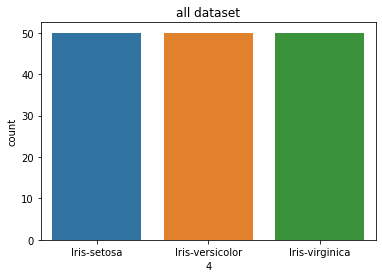

In [9]:
sns.countplot(x = df[4]);plt.title('all dataset')

In [85]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

def iris_preprocess(df, seed = 1):
  # x,y 분할
  x = df.values[:, :-1] # (전체샘플, 마지막 변수 전까지)
  y = df.values[:, -1] # (전체샘플, 마지막 변수)

  # 정규화 (x 데이터만 정규화)
  ss = StandardScaler()
  x = ss.fit_transform(x)

  # 3개이상의 y분류는 원핫인코딩
  oh = OneHotEncoder(sparse = False)
  y = oh.fit_transform(np.expand_dims(y, 1)) # 인풋이 무조건 행렬 (150, ) -> (150, 1) 
  print(f'원핫 변환 순서: {oh.categories_}')
  
  # train-test 분할
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,
                                                      random_state = seed,
                                                      stratify = y)
  return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = iris_preprocess(df)
print(f'데이터 형태: {x_train.shape}, {x_test.shape}, {y_train.shape}, {y_test.shape}')
print(f'첫번째 샘플 x: {x_train[0]} y: {y_train[0]}')

원핫 변환 순서: [array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)]
데이터 형태: (105, 4), (45, 4), (105, 3), (45, 3)
첫번째 샘플 x: [ 0.55333328 -0.58776353  0.76275864  0.39617188] y: [0. 0. 1.]


* 예측값 분포 확인

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Text(0.5, 1.0, 'test dataset')

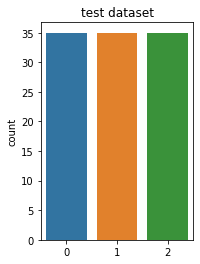

In [86]:
plt.subplot(121);sns.countplot(x = np.argmax(y_train, axis = 1));plt.title('train dataset')
plt.subplot(121);sns.countplot(x = np.argmax(y_test, axis = 1));plt.title('test dataset')

### | 모델


<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0105-02.PNG?raw=true width=800>
</p>


#### **모델 생성**

In [87]:
from tensorflow.keras import models, layers, utils

def build_model():
  x = layers.Input(shape = (4,))
  z = layers.Dense(12, activation = 'relu')(x)
  z = layers.Dense(8, activation = 'relu')(z)
  y = layers.Dense(3, activation = 'softmax')(z) 
  model = models.Model(x, y, name='iris_clasification')

  return model

#### **모델 시각화**

* `model.summary()`
* `utils.plot_model()`

Model: "iris_clasification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_24 (Dense)            (None, 12)                60        
                                                                 
 dense_25 (Dense)            (None, 8)                 104       
                                                                 
 dense_26 (Dense)            (None, 3)                 27        
                                                                 
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________


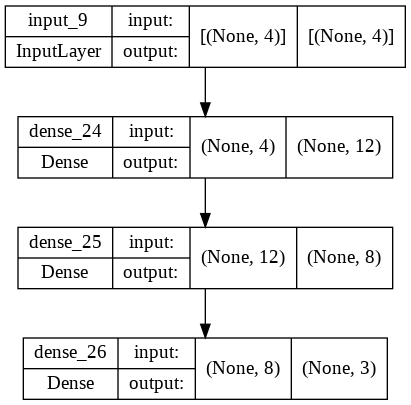

In [88]:
model = build_model()
model.summary()
utils.plot_model(model, show_shapes = True)

### | 학습

#### **모델 컴파일**

```
model.compile(loss, optimizer, metrics) 
```
* `loss` : 다중분류 문제, 'categorical_crossentropy'
* `optimizer` : 문제와 상관없음. 'adam'
* `metrics`: accuracy


In [26]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

#### **학습**

```
model.fit(x_train, y_train, epochs, batch_size)
```
* `x_train` : 넘파이 혹은 텐서 형식의 인풋 데이터
* `y_train` : 넘파이 혹은 텐서 형식의 아웃풋 데이터
* `epochs` : 학습 횟수
* `batch_size` : 배치 사이즈 ((업데이트 한번에 사용될 샘플 개수)

In [ ]:
model.fit(x_train, y_train, epochs = 100, batch_size = 8)

### | 검증 및 예측


#### **검증**

```
model.evaluate(x_test, y_test)
```
* `x_test` : 넘파이 혹은 텐서 형식의 인풋 테스트 데이터
* `y_test` : 넘파이 혹은 텐서 형식의 아웃풋 테스트 데이터

In [29]:
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 8ms/step - loss: 0.1052 - accuracy: 0.9778


[0.10521200299263, 0.9777777791023254]

#### **예측**

```
model.predict(x_test)
```
* `x_test` : 넘파이 혹은 텐서 형식의 인풋 테스트 데이터
* `y_test` : 넘파이 혹은 텐서 형식의 아웃풋 테스트 데이터

In [31]:
y_pred = model.predict(x_test)
print(y_test.shape, y_pred.shape)
print(y_test[0], y_pred[0])
# 원핫 인코딩 -> 라벨
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
print(y_test.shape, y_pred.shape)
print(y_test[0], y_pred[0])

(45, 3) (45, 3)
[1. 0. 0.] [9.9977273e-01 2.2718302e-04 1.2569585e-07]
(45,) (45,)
0 0


* 예측 시각화

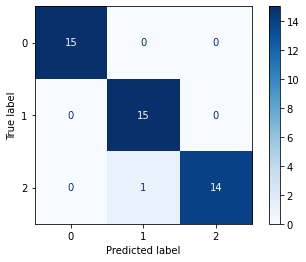

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
#print(cm)
ConfusionMatrixDisplay(cm).plot(cmap = 'Blues')

## 과제
---

### | 과제1. 다중분류 문제 정리

* 예측값의 범위 : 0~1 사이 모든 분류된 예측값들을 더하면 1이 된다.
* 예측값의 shape : (샘플개수,), or (샘플개수,3)
* 아웃풋 레이어의 노드 개수 : 3
* 아웃풋 레이어의 activation : 'softmax', 이중분류면 sigmoid를 사용함
* 손실함수 (loss) : 'categorical_corssentropy'
* 평가함수 (metrics) : 'accuracy'

### | 과제2. 한 셀에 코드 정리하기

* 추가 연습
  * 모델의 깊이(depth)를 늘려가며 학습해 보세요.
  * 모델의 너비(width)를 늘려가며 학습해 보세요.

In [89]:
data_path = '/content/-Deep_learning/dataset/iris.csv'
df = pd.read_csv(data_path, header = None)

원핫 변환 순서: [array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)]
Epoch 1/100
14/14 [==============================] - 0s 3ms/step - loss: 0.9182 - accuracy: 0.6286
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 0.8797 - accuracy: 0.7905
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 0.8415 - accuracy: 0.7810
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 0.8054 - accuracy: 0.7714
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 0.7704 - accuracy: 0.7333
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 0.7359 - accuracy: 0.7143
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 0.7026 - accuracy: 0.6476
Epoch 8/100
14/14 [==============================] - 0s 3ms/step - loss: 0.6715 - accuracy: 0.6476
Epoch 9/100
14/14 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6476
Epoch 10/100
14/14 [===

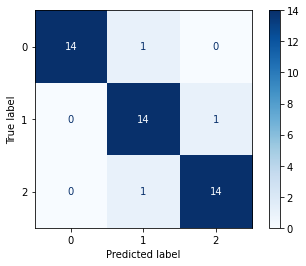

In [90]:
# 필요 라이브러리 추출

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 데이터 전처리 과정
def iris_preprocess(df, seed = 1):
  # x,y 분할
  x = df.values[:, :-1] # (전체샘플, 마지막 변수 전까지)
  y = df.values[:, -1] # (전체샘플, 마지막 변수)

  # 정규화 (x 데이터만 정규화)
  ss = StandardScaler()
  x = ss.fit_transform(x)

  # 3개이상의 y분류는 원핫인코딩
  oh = OneHotEncoder(sparse = False)
  y = oh.fit_transform(np.expand_dims(y, 1)) # 인풋이 무조건 행렬 (150, ) -> (150, 1) 
  print(f'원핫 변환 순서: {oh.categories_}')
  
  # train-test 분할
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,
                                                      random_state = seed,
                                                      stratify = y)
  return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = iris_preprocess(df)
# print(f'데이터 형태: {x_train.shape}, {x_test.shape}, {y_train.shape}, {y_test.shape}')
# print(f'첫번째 샘플 x: {x_train[0]} y: {y_train[0]}')

# 모델 생성

def build_model():
  x = layers.Input(shape = (4,))
  z = layers.Dense(20, activation = 'relu')(x)
  z = layers.Dense(15, activation = 'relu')(z)
  y = layers.Dense(3, activation = 'softmax')(z) 
  model = models.Model(x, y, name='iris_clasification')

  return model

# 모델 컴파일 

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

# 학습 및 검증

model.fit(x_train, y_train, epochs = 100, batch_size = 8)
model.evaluate(x_test, y_test)

# 예측
# 원핫 인코딩 -> 라벨
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

# 결과 시각화

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap = 'Blues')

### | 과제 3. MNIST 숫자 데이터 분류

```
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
```

In [92]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 정규화 (x)
x_train = x_train/255.0 # (0~1)
x_test = x_test/255.0

# 원핫 (y)
oh = OneHotEncoder(sparse = False)
y_train = oh.fit_transform(np.expand_dims(y_train, 1))
y_test = oh.fit_transform(np.expand_dims(y_test, 1))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000, 10) (10000, 28, 28) (10000, 10)


* 데이터 시각화

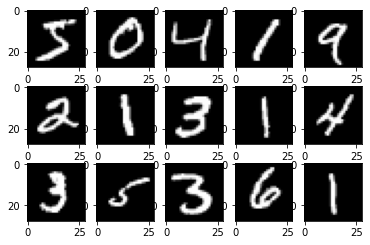

In [93]:
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.imshow(x_train[i], cmap ='gray')

### | 모델


<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0105-03.PNG?raw=true width=500>
</p>


#### **모델 생성**

In [94]:
from tensorflow.keras import models, layers, utils

def build_mnistmodel():
  x = layers.Input(shape = (28, 28))
  z = layers.Flatten()(x)
  # 중간층
  z = layers.Dense(600, activation = 'relu')(z)
  z = layers.Dense(400, activation = 'relu')(z)
  
  y = layers.Dense(10, activation = 'softmax')(z)

  model = models.Model(x, y, name='mnist_classification')


  return model

#### **모델 시각화**

* `model.summary()`
* `utils.plot_model()`

Model: "mnist_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_30 (Dense)            (None, 600)               471000    
                                                                 
 dense_31 (Dense)            (None, 400)               240400    
                                                                 
 dense_32 (Dense)            (None, 10)                4010      
                                                                 
Total params: 715,410
Trainable params: 715,410
Non-trainable params: 0
_________________________________________________________________


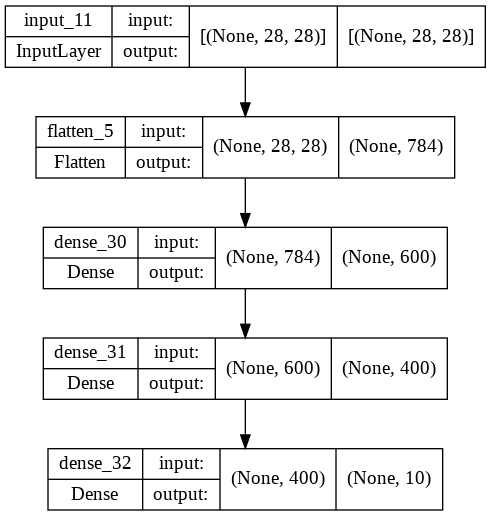

In [95]:
model = build_mnistmodel()
model.summary()
utils.plot_model(model, show_shapes = True)

### | 학습

#### **모델 컴파일**

```
model.compile(loss, optimizer, metrics) 
```
* `loss` : 다중분류 문제
    * categorical_crossentropy: 원핫 완료된 상태, 
    * sparse_categorical_crossentropy: 원핫 안된상태
* `optimizer` : 'adam'
* `metrics`: 'accuracy' 


In [96]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

#### **학습**

```
model.fit(x_train, y_train, epochs, batch_size)
```
* `x_train` : 넘파이 혹은 텐서 형식의 인풋 데이터
* `y_train` : 넘파이 혹은 텐서 형식의 아웃풋 데이터
* `epochs` : 학습 횟수
* `batch_size` : 배치 사이즈 ((업데이트 한번에 사용될 샘플 개수)

In [98]:
model.fit(x_train, y_train, epochs = 5, batch_size = 8)

Epoch 1/5
7500/7500 [==============================] - 20s 3ms/step - loss: 0.1338 - accuracy: 0.9606
Epoch 2/5
7500/7500 [==============================] - 20s 3ms/step - loss: 0.0874 - accuracy: 0.9734
Epoch 3/5
7500/7500 [==============================] - 18s 2ms/step - loss: 0.0694 - accuracy: 0.9803
Epoch 4/5
7500/7500 [==============================] - 18s 2ms/step - loss: 0.0576 - accuracy: 0.9836
Epoch 5/5
7500/7500 [==============================] - 18s 2ms/step - loss: 0.0508 - accuracy: 0.9859


### | 검증 및 예측


#### **검증**

```
model.evaluate(x_test, y_test)
```
* `x_test` : 넘파이 혹은 텐서 형식의 인풋 테스트 데이터
* `y_test` : 넘파이 혹은 텐서 형식의 아웃풋 테스트 데이터

In [78]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1911 - accuracy: 0.9730


[0.1911337822675705, 0.9729999899864197]

#### **예측**

```
model.predict(x_test)
```
* `x_test` : 넘파이 혹은 텐서 형식의 인풋 테스트 데이터
* `y_test` : 넘파이 혹은 텐서 형식의 아웃풋 테스트 데이터

In [79]:
y_pred = model.predict(x_test)
print(y_test.shape, y_pred.shape)
print(y_test[0], y_pred[0])
# 원핫 인코딩 -> 라벨
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
print(y_test.shape, y_pred.shape)
print(y_test[0], y_pred[0])

(10000, 10) (10000, 10)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] [4.3118102e-21 3.7501216e-16 1.4083269e-17 4.7474507e-11 8.0185994e-16
 1.2291489e-22 1.1014657e-37 1.0000000e+00 5.2520845e-18 9.8521656e-11]
(10000,) (10000,)
7 7


* 예측 시각화

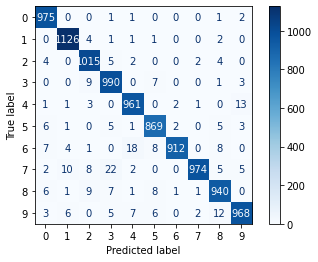

In [80]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap = 'Blues')

* 모델 활용

(60000, 28, 28) (60000, 10) (10000, 28, 28) (10000, 10)
Model: "mnist_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_33 (Dense)            (None, 600)               471000    
                                                                 
 dense_34 (Dense)            (None, 400)               240400    
                                                                 
 dense_35 (Dense)            (None, 10)                4010      
                                                                 
Total params: 715,410
Trainable params: 715,410
Non-trainable params: 0
__________________________________________________

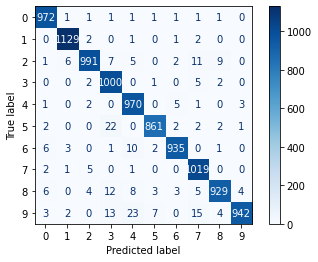

In [99]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 정규화 (x)
x_train = x_train/255.0 # (0~1)
x_test = x_test/255.0

# 원핫 (y)
oh = OneHotEncoder(sparse = False)
y_train = oh.fit_transform(np.expand_dims(y_train, 1))
y_test = oh.fit_transform(np.expand_dims(y_test, 1))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

from tensorflow.keras import models, layers, utils


# 모델 생성
def build_mnistmodel():
  x = layers.Input(shape = (28, 28))
  z = layers.Flatten()(x)
  # 중간층
  z = layers.Dense(600, activation = 'relu')(z)
  z = layers.Dense(400, activation = 'relu')(z)
  
  y = layers.Dense(10, activation = 'softmax')(z)

  model = models.Model(x, y, name='mnist_classification')


  return model

# 모델 시각화
model = build_mnistmodel()
model.summary()
utils.plot_model(model, show_shapes = True)

# 모델 컴파일
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

# 모델 학습
model.fit(x_train, y_train, epochs = 5, batch_size = 8)

# 모델 검증
model.evaluate(x_test, y_test)

# 예측
# 원핫 인코딩 -> 라벨
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

# 결과 시각화
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap = 'Blues')